In [65]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

In [66]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Hyperparameters
batch_size = 128
epochs = 2
learning_rate = 0.001
sparse_lambda = 1e-3  # Sparsity penalty
contractive_lambda = 1e-4  # Contractive penalty
rho = 0.05  # Target sparsity
epsilon = 1e-6

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [67]:
# U-Net-like Encoder
def build_encoder():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)  # 28x28x64
    x = layers.MaxPooling2D(2)(x)  # 14x14x64
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)  # 14x14x128
    x = layers.MaxPooling2D(2)(x)  # 7x7x128
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)  # 7x7x256
    x = layers.MaxPooling2D(2)(x)  # 3x3x256
    x = layers.Flatten()(x)
    z = layers.Dense(128)(x)  # Latent space
    return models.Model(inputs, z, name='encoder')


In [68]:
# U-Net-like Decoder
def build_decoder():
    inputs = layers.Input(shape=(128,))
    x = layers.Dense(256 * 3 * 3, activation='relu')(inputs)
    x = layers.Reshape((3, 3, 256))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 6x6x128
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 12x12x64
    x = layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(x)  # 28x28x1
    x = layers.Conv2D(1, 3, padding='valid', activation='sigmoid')(x)  # 22x22x1
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(x)  # 28x28x1
    return models.Model(inputs, x, name='decoder')

In [69]:
# Sparse Autoencoder
class SparseAutoencoder(models.Model):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, inputs):
        z = self.encoder(inputs)
        recon = self.decoder(z)
        return recon, z

In [70]:
# Contractive Autoencoder
class ContractiveAutoencoder(models.Model):
    def __init__(self):
        super(ContractiveAutoencoder, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def call(self, inputs):
        z = self.encoder(inputs)
        recon = self.decoder(z)
        return recon, z

In [71]:
def sparse_ae_loss(y_true, y_pred, z):
    mse_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
    rho_hat = tf.reduce_mean(z, axis=0)
    # Clip rho_hat to avoid log(0) or division by zero
    rho_hat = tf.clip_by_value(rho_hat, epsilon, 1 - epsilon)
    kl_div = rho * tf.math.log(rho / rho_hat) + (1 - rho) * tf.math.log((1 - rho) / (1 - rho_hat))
    kl_loss = sparse_lambda * tf.reduce_sum(tf.clip_by_value(kl_div, -1e4, 1e4))  # Clip KL term
    return mse_loss + kl_loss

# Contractive Autoencoder Loss
def contractive_ae_loss(x, recon, z, model):
    mse_loss = tf.reduce_mean(tf.square(x - recon))
    with tf.GradientTape() as tape:
        tape.watch(z)
        recon = model.decoder(z)
    grad_z = tape.gradient(recon, z)
    j_loss = contractive_lambda * tf.reduce_mean(tf.reduce_sum(tf.square(grad_z), axis=1))
    return mse_loss + j_loss

In [72]:
# Training function
def train(model, dataset, loss_fn, epochs, model_type='sparse'):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataset:
            with tf.GradientTape() as tape:
                recon, z = model(batch)
                if model_type == 'sparse':
                    loss = loss_fn(batch, recon, z)
                else:
                    loss = loss_fn(batch, recon, z, model)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total_loss += loss.numpy()
        print(f'Epoch {epoch+1}/{epochs}, {model_type.capitalize()} AE Loss: {total_loss / len(dataset):.6f}')

In [73]:
# Initialize and compile models
sparse_ae = SparseAutoencoder()
contractive_ae = ContractiveAutoencoder()

# Print model summary
print("Sparse Autoencoder Summary:")
sparse_ae.summary()

print("\nContractive Autoencoder Summary:")
contractive_ae.summary()

# Train Sparse Autoencoder
print("Training Sparse Autoencoder...")
train(sparse_ae, train_dataset, sparse_ae_loss, epochs, model_type='sparse')

# Train Contractive Autoencoder
print("\nTraining Contractive Autoencoder...")
train(contractive_ae, train_dataset, contractive_ae_loss, epochs, model_type='contractive')

Sparse Autoencoder Summary:


Model: "sparse_autoencoder_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 128)            │       664,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       666,635 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,339 (5.08 MB)

 Trainable params: 1,331,339 (5.08 MB)

 Non-trainable params: 0 (0.00 B)


Contractive Autoencoder Summary:


Model: "contractive_autoencoder_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 128)            │       664,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       666,635 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,339 (5.08 MB)

 Trainable params: 1,331,339 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Training Sparse Autoencoder...
Epoch 1/2, Sparse AE Loss: 0.075740
Epoch 2/2, Sparse AE Loss: 0.038379

Training Contractive Autoencoder...
Epoch 1/2, Contractive AE Loss: 0.120827
Epoch 2/2, Contractive AE Loss: 0.098976



Reconstructing and Validating Sparse Autoencoder...
Sparse Autoencoder Test MSE: 0.020710


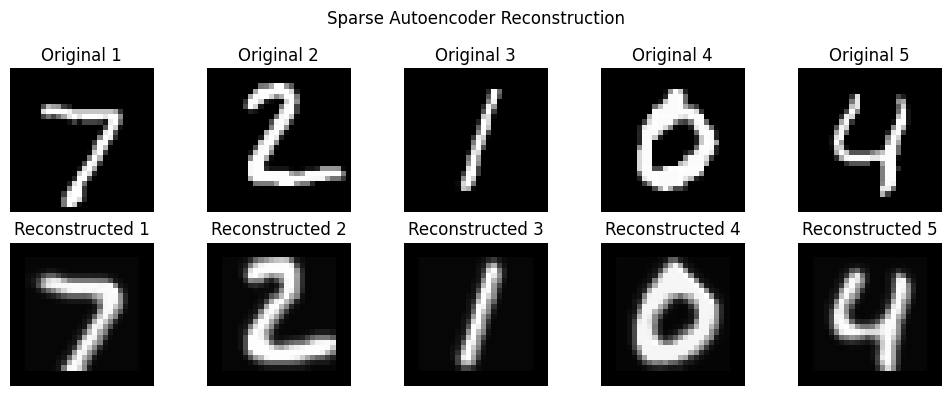


Reconstructing and Validating Contractive Autoencoder...
Contractive Autoencoder Test MSE: 0.089434


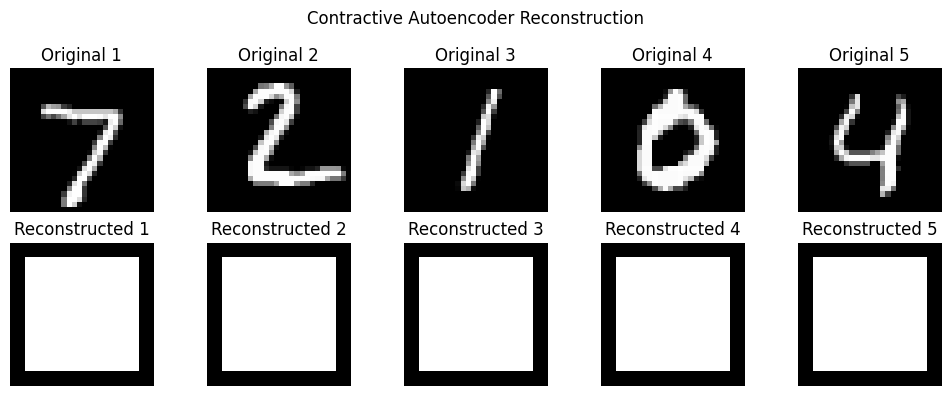

In [76]:

import matplotlib.pyplot as plt
# Load and preprocess MNIST dataset (modified to include test set)
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)  # Shape: (10000, 28, 28, 1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).cache().shuffle(60000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Function to reconstruct and validate images
def reconstruct_and_validate(model, dataset, model_name, num_images=5):
    # Get one batch from the test dataset
    for batch in dataset.take(1):
        original_images = batch.numpy()
        recon_images, _ = model(batch, training=False)
        recon_images = recon_images.numpy()

    # Compute MSE for the batch
    mse = np.mean((original_images - recon_images) ** 2)
    print(f"{model_name} Test MSE: {mse:.6f}")

    # Visualize original and reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')
        # Reconstructed image
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    plt.suptitle(f"{model_name} Reconstruction")
    plt.tight_layout()
    plt.show()

# After training, reconstruct and validate
print("\nReconstructing and Validating Sparse Autoencoder...")
reconstruct_and_validate(sparse_ae, test_dataset, "Sparse Autoencoder")

print("\nReconstructing and Validating Contractive Autoencoder...")
reconstruct_and_validate(contractive_ae, test_dataset, "Contractive Autoencoder")